# Polytop FDB Access

## Installation
See instruction in [Polytope installation](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation-1)

**Configuring Access to Polytope**

In [ ]:
import os
import dataclasses as dc
from meteodatalab import mars, mch_model_data

#ECMWF polytope credentials
# leave empty for ICON-CSCS polytope
os.environ["POLYTOPE_USER_KEY"] = ""
os.environ["POLYTOPE_USER_EMAIL"] = ""

#ICON-CSCS polytope credentials
# leave empty for ecmwf polytope
os.environ["POLYTOPE_USER_KEY"] = "xxxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"
os.environ["POLYTOPE_LOG_LEVEL"] = "INFO"

**Selecting date,time of the forecast**

In [ ]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 6
rounded_hour = (past_time.hour // 6) * 6
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time


**Querying the data**

In [59]:
request = mars.Request(
    param="T_2M",
    date=date,
    time=time,
    model=mars.Model.ICON_CH1_EPS,
    levtype=mars.LevType.SURFACE,
    number=range(1, 11),
    step=0
)

In [ ]:
ds = mch_model_data.get_from_polytope(request)

In [61]:
ds_temp = ds["T_2M"]
lons = ds_temp["lon"].values
lats = ds_temp["lat"].values

**Mask gridded data to the shape of switzerland**

In [62]:
import geopandas as gpd

swiss = gpd.read_file('swissBOUNDARIES3D_1_5_TLM_LANDESGEBIET.shp')

points = gpd.GeoSeries.from_xy(lons.ravel(), lats.ravel(), crs="EPSG:4326")

swiss = swiss.to_crs("EPSG:4326")

mask = points.within(swiss.geometry.iloc[1])
mask_2d = mask.values.reshape(lats.shape)

ds_masked = ds_temp.where(mask_2d)

**Convert to degree celcius**

In [63]:
temp2m_m = ds_masked.mean(dim='eps', keep_attrs=True)
temp2m_m.values = temp2m_m.values - 273.15

**Regrid**

In [64]:
from meteodatalab.operators.regrid import regrid, RegularGrid, Resampling, CRS

dst = RegularGrid(
    crs=CRS.from_epsg(21781),
    xmin=400000,
    xmax=900000,
    ymin=50000,
    ymax=350000,
    nx=500,
    ny=300,
)
t_final = regrid(temp2m_m, dst, Resampling.bilinear)


**Plot the results**

Text(0.5, 1.0, '2 Meter Temperature Mean')

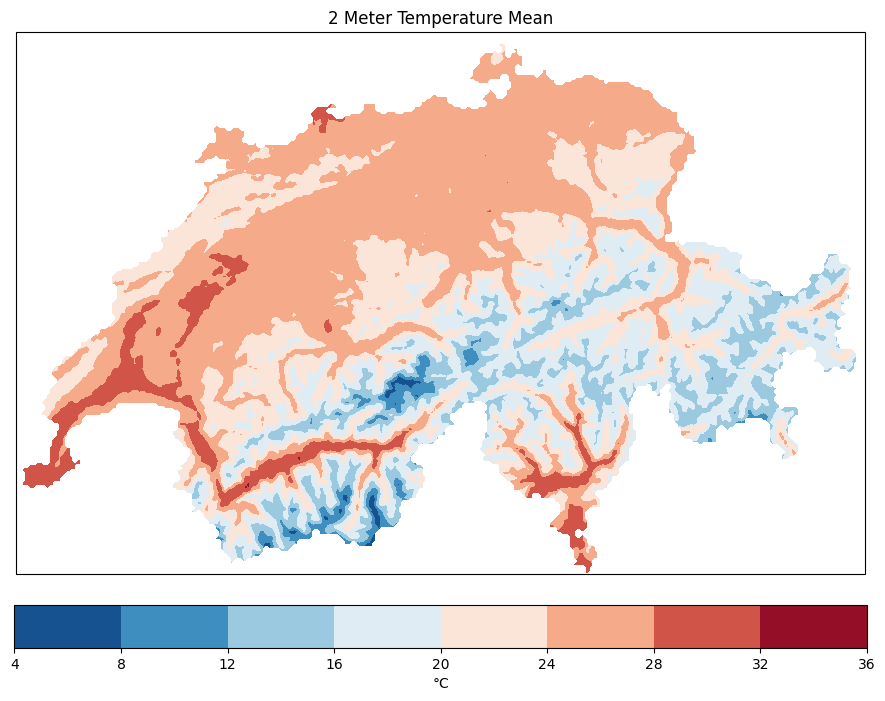

In [73]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

crs = ccrs.epsg(21781)
fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(1, 1, 1, projection=crs)

f = t_final.squeeze()
c = ax.contourf(dst.x, dst.y, f.values, transform=crs, cmap='RdBu_r')
fig.colorbar(c, label="°C", orientation="horizontal", fraction=0.07, pad=0.05)

ax.set_title("2 Meter Temperature Mean")